In [1]:
import datetime as dt
import pandas_datareader.data as web
from matplotlib import style
import matplotlib.pyplot as plt
import math 
import numpy as np
import yfinance as yf
import pandas as pd
from scipy import optimize as scopti
import bs4 as bs
import pickle
import requests

In [2]:
import data
import risk_metrics as rm
import markowitz_construction as mc
import risk_budgeted_construction as rbc

### Extracting Dow Jones Industrial Avg Index & Caculating Statistics of all its Constituents

In [3]:
def djia_components():
    resp = requests.get('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        tickers.append(ticker.rsplit(":")[-1].strip())
  
    return tickers 

In [4]:
tickers_list=['^DJI']+djia_components()

In [5]:
prices=data.data_pandas_reader_tenor(tickers_list,'2y','1d',field='Adj Close')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
prices2=prices.dropna(axis=1)
gross_returns=mc.stock_returns(prices2)

In [7]:
summary=rm.summary_stats(gross_returns, 0.01,period_freq=252).sort_values(by=['Sharpe Ratio','Max Drawdown'], ascending=False)

### Creating a set of Risky Stocks using Top 15 Dow Jones Stocks over 2 years

In [8]:
constituents=summary.index[0:15]
constituent_prices=prices2[constituents].drop(['^DJI'], axis=1)
equity_portfolio=pd.DataFrame(mc.stock_returns(constituent_prices))
equity_portfolio.tail()

,AAPL,MSFT,HD,UNH,NKE,GS,MCD,PG,CRM,CAT,CSCO,JNJ,WMT,AXP
Date,,,,,,,,,,,,,,
2021-12-17,-0.006502,-0.003386,-0.028909,-0.011646,-0.008358,-0.039183,-0.014498,-0.022655,-0.000751,-0.023282,0.002487,-0.027628,-0.032022,-0.018344
2021-12-20,-0.008122,-0.012014,0.003660,-0.006959,-0.027144,-0.026689,0.000115,0.002540,-0.022615,-0.029349,-0.001654,-0.002853,0.003243,-0.025748
2021-12-21,0.019087,0.023069,0.002748,0.007194,0.061473,0.023439,0.010163,-0.000634,0.021601,0.014581,0.011100,-0.003219,0.003017,0.032202
2021-12-22,0.015319,0.018057,0.013240,0.014203,-0.007142,0.005285,0.002080,0.009889,0.000990,0.019364,0.008193,0.004306,0.001289,0.009695
2021-12-23,0.003644,0.004472,0.003614,0.002530,0.001390,0.007088,0.003812,0.004896,0.001345,0.020035,0.012189,0.001906,-0.002217,0.010587


### Using Treasury  ETFs as safe assets

In [9]:
bond_etf=data.data_pandas_reader_tenor(['AGG','TIP'],'2y','1d',field='Adj Close')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
bond_portfolio= pd.DataFrame(mc.stock_returns(bond_etf))
bond_portfolio.tail()

,AGG,TIP
Date,,
2021-12-17,0.001224,0.000078
2021-12-20,-0.001485,-0.000547
2021-12-21,-0.000787,0.002190
2021-12-22,0.000875,0.003200
2021-12-23,-0.001224,-0.002257


In [11]:
portfolio= equity_portfolio.merge(bond_portfolio,how='left',left_index=True, right_index=True)
portfolio.head()

,AAPL,MSFT,HD,UNH,NKE,GS,MCD,PG,CRM,CAT,CSCO,JNJ,WMT,AXP,AGG,TIP
Date,,,,,,,,,,,,,,,,
2019-12-26,0.019841,0.008196,0.000680,0.003769,0.005692,0.005654,0.001983,0.000000,0.007718,0.005018,0.001465,-0.000685,0.000084,0.005371,0.000890,0.000687
2019-12-27,-0.000379,0.001828,-0.003849,0.001082,0.008539,-0.002379,0.005633,0.006948,0.002857,0.000405,-0.001672,-0.000549,0.000586,-0.001754,0.001334,0.000343
2019-12-30,0.005935,-0.008619,-0.012092,-0.007163,-0.007581,-0.003728,-0.006358,-0.012848,-0.015396,-0.005126,-0.003768,-0.003088,-0.001589,-0.007109,0.000000,0.000343
2019-12-31,0.007307,0.000698,0.004924,0.000443,0.005059,0.000566,0.003555,0.003455,0.001231,0.001084,0.007775,0.003923,-0.004690,0.001528,-0.002308,-0.001028
2020-01-02,0.022816,0.018516,0.005862,-0.005034,0.008785,0.019093,0.016092,-0.011929,0.026746,0.019299,0.017013,0.000686,0.000841,0.014428,0.002759,0.004890


### Assigning Equal Risk Weights for both portfolios using Risk Budgeting Framework leading to the Risk Parity Portfolio (RPP), which is a special case of Risk Budgeted Portfolios

In [12]:
n=portfolio.shape[1]
n_equity=equity_portfolio.shape[1]
n_bond=bond_portfolio.shape[1]

risk_budget=np.append(np.repeat(1/n_equity,n_equity),np.repeat(1/n_bond,n_bond)).reshape(-1,1)
optimal_weights=rbc.risk_budgeted_backtest(equity_portfolio, bond_portfolio, risk_budget)
rpp_portfolio=portfolio.dot(optimal_weights)
optimal_weights

array([0.02343285, 0.02342609, 0.02332081, 0.02408661, 0.02680374,
       0.0210737 , 0.02711572, 0.03718303, 0.0244158 , 0.02765454,
       0.02652568, 0.04096354, 0.04662431, 0.01823845, 0.26271489,
       0.34642024])

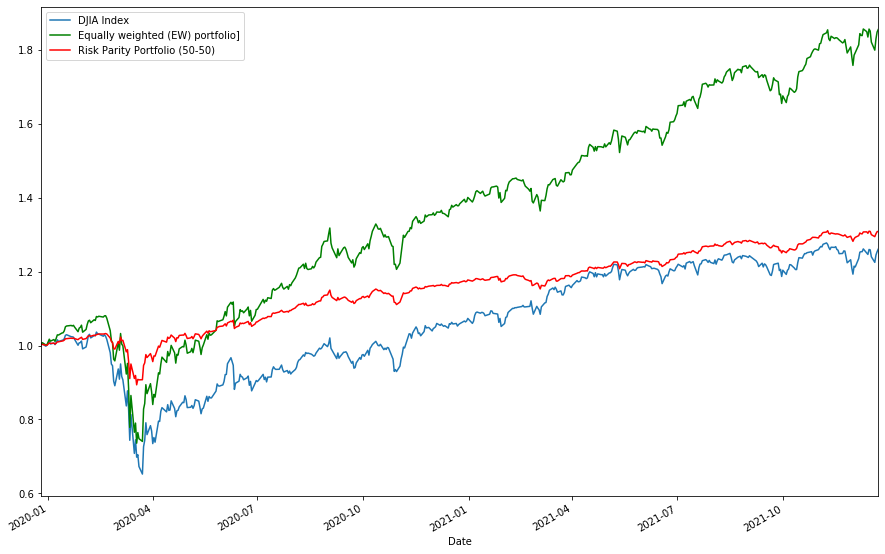

In [13]:
ax=mc.cumulative_returns(gross_returns['^DJI']).plot.line(x="Date", y="Cumulative Returns",figsize=(15,10), 
                                                                label='DJIA Index')
ax.plot(mc.cumulative_returns(portfolio.dot(risk_budget)),color='green', label='Equally weighted (EW) portfolio]')
ax.plot(mc.cumulative_returns(rpp_portfolio),color='red', label='Risk Parity Portfolio (50-50)')
plt.legend()

In [15]:
concat_rets=pd.concat([gross_returns['^DJI'],portfolio.dot(risk_budget), rpp_portfolio], axis=1)
concat_rets.columns=['DJIA Index','Equally Weighted', 'Risk Parity Portfolio (50-50)']

In [16]:
rm.summary_stats(concat_rets, 0.01,period_freq=252)

,Annualized Return,Annualized Vol,Skewness,Excess Kurtosis,Cornish-Fisher VaR (5%),Gaussian VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
DJIA Index,0.122827,0.274559,-0.584380,15.436635,0.025187,0.027810,0.043137,0.406880,-0.370862
Equally Weighted,0.362051,0.269465,-0.485455,18.729323,0.022377,0.026521,0.040334,1.293596,-0.319287
Risk Parity Portfolio (50-50),0.144134,0.102842,-0.711847,19.424045,0.008801,0.010090,0.015339,1.291417,-0.134431


## Portfolio Allocation v/s Risk Allocation in a Risk Parity Portfolio

In [17]:
df=pd.DataFrame(rbc.risk_contribution(optimal_weights, portfolio.cov()).T
                ,columns=portfolio.columns,index=['Relative Risk Contribution']).T
df['Portfolio Allocation']=optimal_weights.T

Text(0, 0.5, 'Allocation')

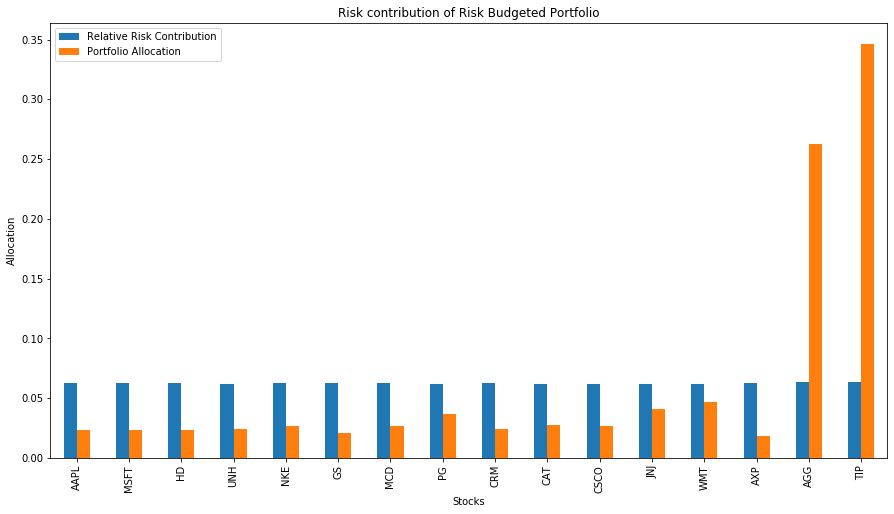

In [18]:
df.plot(kind="bar",figsize=(15, 8))

plt.title("Risk contribution of Risk Budgeted Portfolio")
plt.xlabel("Stocks")
plt.ylabel("Allocation")

## Portfolio Allocation v/s Risk Allocation in a Equally Weighted Portfolio

In [19]:
weight_ew=np.repeat(1/n,n).reshape(-1,1)
df2=pd.DataFrame(rbc.risk_contribution(weight_ew, portfolio.cov()).T
                ,columns=portfolio.columns,index=['Relative Risk Contribution']).T
df2['Portfolio Allocation']=weight_ew

Text(0, 0.5, 'Allocation')

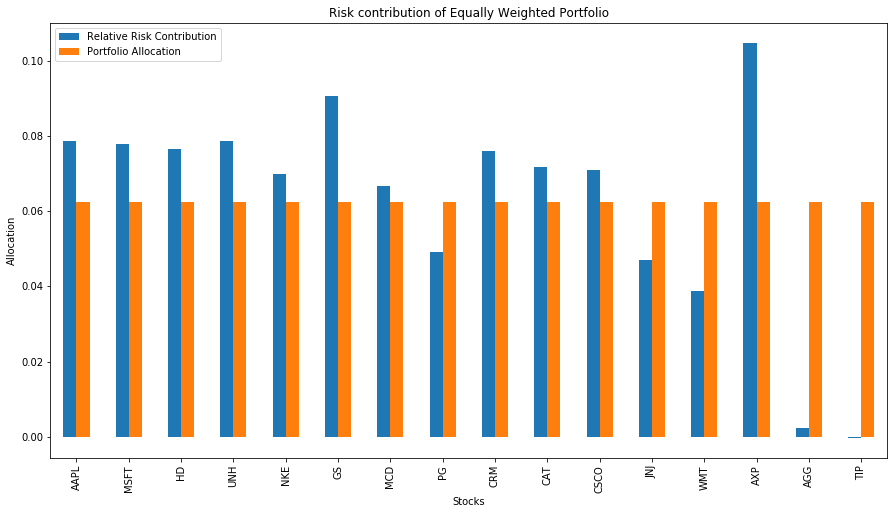

In [20]:
df2.plot(kind="bar",figsize=(15, 8))

plt.title("Risk contribution of Equally Weighted Portfolio")
plt.xlabel("Stocks")
plt.ylabel("Allocation")